# Лабораторная работа №2. Реализация глубокой нейронной сети

### Данные: В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

Ниже будут прописаны все библиотеки, которые мы используем в лабораторной работе

In [5]:
import pathlib
import requests
import tarfile
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

### ЭТАП 1. Подготовительный

#### Здесь мы загрузим данные, избавимся от дупликатов и перемешаем данные. Код взят из лабораторной работы 1

#### Загрузим данные

In [184]:
url = "https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz"
download_dir = "notMNIST_dataset_big"


if not os.path.exists(download_dir):
    os.makedirs(download_dir)

response = requests.get(url)
with open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "wb") as f:
    f.write(response.content)

with tarfile.open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "r:gz") as tar:
    tar.extractall(download_dir)

print("Данные успешно загружены и извлечены.")

Данные успешно загружены и извлечены.


In [6]:
download_dir = "notMNIST_dataset_big"

In [7]:
data_dir = os.path.join(download_dir, "notMNIST_large")
data_dir = pathlib.Path(data_dir)
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

#### Перед тем как делить данные на выборки, "перемешаем" между собой картинки из разных папок собой, чтобы не получилось так, что в одной выборке все буквы одного из классов, а в другой выборке букв этого класса вообще нет


In [8]:
image_paths = list(data_dir.glob("*/*.png"))
image_paths.sort()
random.shuffle(image_paths)

#### Избавимся от дупликатов изображений

Для начала напишем функцию для вычисления дифференциального хеша (dHash) изображения, чтобы было проще убрать дупликаты

In [9]:
def dhash(image, hash_size=8):
    # Изменяем размер изображения до размера hash_size + 1 на hash_size  и преобразуем его в оттенки серого
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    hash_string = ""
    
    # Сравниваем пиксели по строкам
    for i in range(hash_size):
        for j in range(hash_size):
            if gray[i, j] > gray[i, j + 1]:
                hash_string += "1"
            else:
                hash_string += "0"

    return hash_string

Создадим словарь, где ключами будут все возможные различные кэши изображений, а значениями будут списки путей к картинкам, у которых конкретный кэш

In [10]:
image_hashes = {}
for image_path in image_paths:
    image = cv2.imread(str(image_path))
    if image is not None:
        if image.shape[0] != 0 and image.shape[1] != 0:
            hashed_image = dhash(image)

            different_hashes = image_hashes.get(hashed_image, [])
            different_hashes.append(image_path)
            
            image_hashes[hashed_image] = different_hashes

А уже следующей функцией удалим все дупликаты изображений и оставим только первые картинки из повторяющихся

In [11]:
images_whithout_duplicates = []
hash_len = 0

for (different_hashes, hashes_paths) in image_hashes.items():
    images_whithout_duplicates.append(hashes_paths[0])
    hash_len += len(hashes_paths)
    
print(f"Было удалено {hash_len - len(images_whithout_duplicates)} дупликатов")

Было удалено 176474 дупликатов


####  Разделим выборку

In [12]:
data = []
labels = []
for file in images_whithout_duplicates:
    image = cv2.imread(str(file))
    
    # Достаём в какой папке (и к какому классу соответственно, относится изображение)
    label = str(file.parent).split('\\')[-1]
    
    # с помощью reshape преобразуем изображение в одномерный массив и нормализуем каждый из 
    # полученных веторов с помощью деления его на 255. Таким образом все числа в массиве от 0 до 1
    # data.append(image.reshape(-1)/255)
    
    data.append(image/255)
    
    # Добавляем в список labels индекс буквы (0-A, 1-B, 2-C,...)
    labels.append(classes.index(label))

In [13]:
print(len(data))

352640


In [16]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data[:220000], np.float32), np.array(labels[:220000], np.float32),
                                                    test_size=20000/220000, random_state=42)

In [17]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))


200000
20000
200000
20000


### ЭТОП 2. Основной

 #### Здесь будет выполнение лабораторной работы 2

#### 1. Реализуем полносвязную нейронную сеть,  у которой будет функция активации ReLu, с помощью библиотек Tensor Flow и Keras


In [18]:
model_relu_act = keras.Sequential([

    keras.layers.Flatten(input_shape=(28, 28, 3)),
    
    # 1-ый слой
    keras.layers.Dense(512, activation=tf.keras.activations.relu),
    
    # 2-ой слой
    keras.layers.Dense(256, activation=tf.keras.activations.relu),
    
    # 3-ий слой
    keras.layers.Dense(128, activation=tf.keras.activations.relu),
    
    # 4-ый слой
    keras.layers.Dense(64, activation=tf.keras.activations.relu),
    
    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

#### "Скомпилируем" нашу модель нейронной сети

In [19]:
model_relu_act.compile(optimizer=keras.optimizers.SGD(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Обучим нашу модель нейронной сети

In [20]:
history_relu = model_relu_act.fit(x_train, y_train, epochs=50, validation_split=20000/200000)

Epoch 1/50
5625/5625 [==============================] - 34s 6ms/step - loss: 0.6707 - accuracy: 0.7999 - val_loss: 0.5505 - val_accuracy: 0.8321
Epoch 2/50
5625/5625 [==============================] - 35s 6ms/step - loss: 0.5087 - accuracy: 0.8453 - val_loss: 0.4810 - val_accuracy: 0.8537
Epoch 3/50
5625/5625 [==============================] - 33s 6ms/step - loss: 0.4464 - accuracy: 0.8630 - val_loss: 0.4506 - val_accuracy: 0.8624
Epoch 4/50
5625/5625 [==============================] - 34s 6ms/step - loss: 0.4041 - accuracy: 0.8757 - val_loss: 0.4478 - val_accuracy: 0.8608
Epoch 5/50
5625/5625 [==============================] - 33s 6ms/step - loss: 0.3719 - accuracy: 0.8848 - val_loss: 0.4221 - val_accuracy: 0.8713
Epoch 6/50
5625/5625 [==============================] - 33s 6ms/step - loss: 0.3455 - accuracy: 0.8932 - val_loss: 0.4035 - val_accuracy: 0.8765
Epoch 7/50
5625/5625 [==============================] - 34s 6ms/step - loss: 0.3224 - accuracy: 0.9001 - val_loss: 0.4119 - val_ac

#### Вычислим точность работы на тестовых данных нашей нейронной сети

In [22]:
_, test_acc = model_relu_act.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of model_relu_act:', test_acc)

Test accuracy of model_relu_act: 0.8849499821662903


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


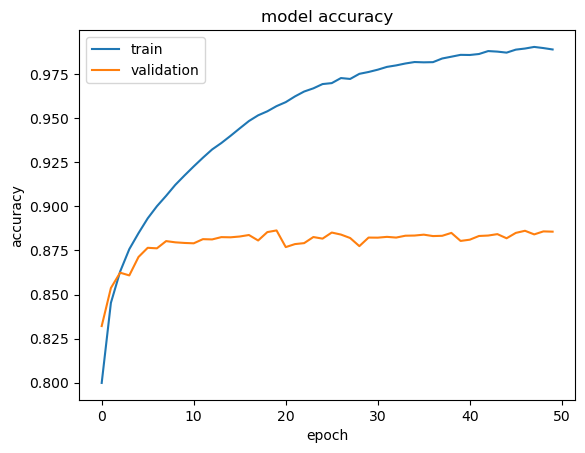

In [23]:
print(history_relu.history.keys())
# summarize history for accuracy
plt.plot(history_relu.history['accuracy'])
plt.plot(history_relu.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

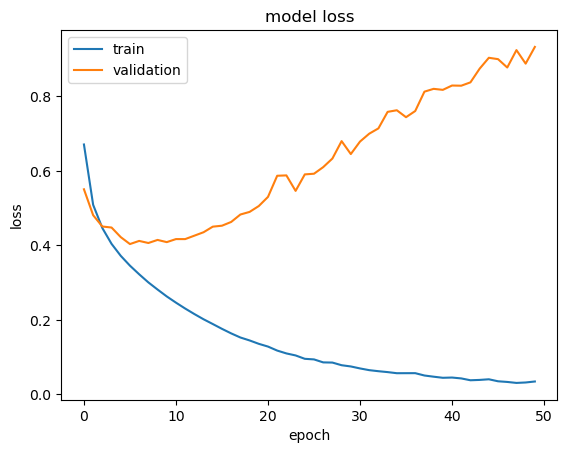

In [24]:
plt.plot(history_relu.history['loss'])
plt.plot(history_relu.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 2. Можно заметить, что по сравнению с логостической регрессией точность у нейронной сети намного выше! Было 0.791, стало 0.884

Достигнутая точность классификации при наборе обучающих данных из 200 000 элементов составляет 88%, а точность обучения тренировочной выборки 98,9%
Но при этом наблюдаются большие потери на валидационной выборке 93%, что может значить, что модель переобучилась

### 3. Будем работать с моделью с функцией активации ReLu. Требуется использовать регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. 

In [27]:
regul_model_relu_act = keras.Sequential([

    keras.layers.Flatten(input_shape=(28, 28, 3)),
    
    # 1-ый слой
    keras.layers.Dense(512, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    # 2-ой слой
    keras.layers.Dense(256, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    # 3-ий слой
    keras.layers.Dense(128, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    # 4-ый слой
    keras.layers.Dense(64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [28]:
regul_model_relu_act.compile(optimizer=keras.optimizers.SGD(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
history_relu_regul = regul_model_relu_act.fit(x_train, y_train, epochs=50, validation_split=20000/200000)

Epoch 1/50
5625/5625 [==============================] - 48s 8ms/step - loss: 0.9489 - accuracy: 0.7562 - val_loss: 0.7329 - val_accuracy: 0.8195
Epoch 2/50
5625/5625 [==============================] - 51s 9ms/step - loss: 0.7535 - accuracy: 0.8159 - val_loss: 0.6659 - val_accuracy: 0.8382
Epoch 3/50
5625/5625 [==============================] - 47s 8ms/step - loss: 0.6945 - accuracy: 0.8321 - val_loss: 0.6249 - val_accuracy: 0.8493
Epoch 4/50
5625/5625 [==============================] - 46s 8ms/step - loss: 0.6533 - accuracy: 0.8433 - val_loss: 0.5954 - val_accuracy: 0.8574
Epoch 5/50
5625/5625 [==============================] - 46s 8ms/step - loss: 0.6262 - accuracy: 0.8501 - val_loss: 0.5762 - val_accuracy: 0.8644
Epoch 6/50
5625/5625 [==============================] - 47s 8ms/step - loss: 0.6005 - accuracy: 0.8569 - val_loss: 0.5601 - val_accuracy: 0.8663
Epoch 7/50
5625/5625 [==============================] - 47s 8ms/step - loss: 0.5823 - accuracy: 0.8624 - val_loss: 0.5518 - val_ac

In [30]:
_, test_acc = regul_model_relu_act.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of regulized_model_sigmoid_act:', test_acc)

Test accuracy of regulized_model_sigmoid_act: 0.8920000195503235


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


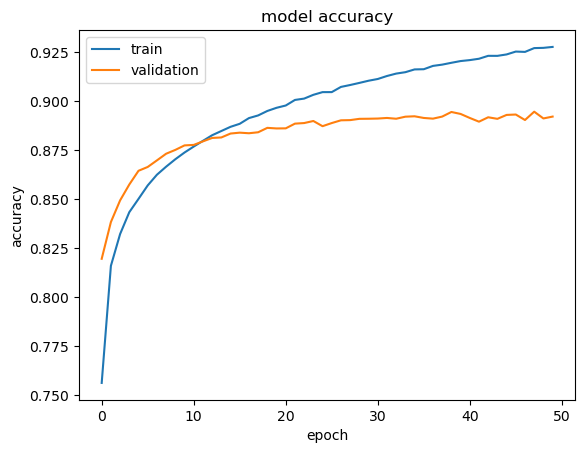

In [31]:
print(history_relu_regul.history.keys())
# summarize history for accuracy
plt.plot(history_relu_regul.history['accuracy'])
plt.plot(history_relu_regul.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

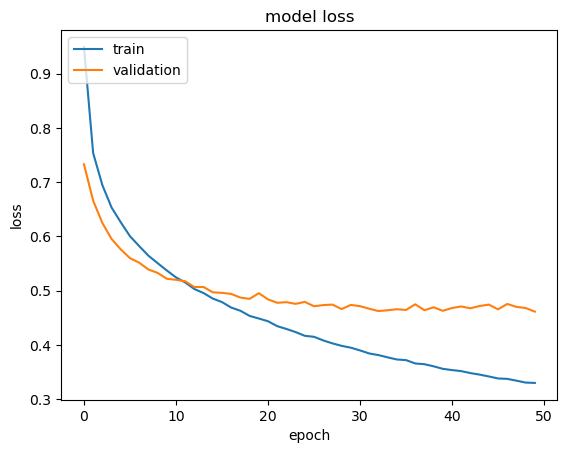

In [32]:
plt.plot(history_relu_regul.history['loss'])
plt.plot(history_relu_regul.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Заметим, что точность возросла, а на графиках меньше "выбросов" и линии тренировочных и валидационных данных начинают преобретать похожий "путь"

Нейронная сеть с использованием регуляризации и методом сброса нейронов не показала существенного увеличения точности классификации – результат улучшился на 1-1,5% точности валидации. При этом точность на обучающей и валидационной выборке сблизилась (линии на графике), что значит, что нейронная сеть начала меньше привыкать к данным и подстраиваться.
Что касается потерь, они уменьшились на валидационной выборке.

### 4. Требуется воспользоваться динамически изменяемой скоростью обучения. 

In [40]:
dynamic_regul_model_relu_act = keras.Sequential([

    keras.layers.Flatten(input_shape=(28, 28, 3)),
    
    # 1-ый слой
    keras.layers.Dense(512, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    # 2-ой слой
    keras.layers.Dense(256, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    # 3-ий слой
    keras.layers.Dense(128, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    # 4-ый слой
    keras.layers.Dense(64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [53]:
schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=schedule)

In [54]:
dynamic_regul_model_relu_act.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
history_relu_regul_dynamic = dynamic_regul_model_relu_act.fit(x_train, y_train, epochs=50, validation_split=20000/200000)

Epoch 1/50
5625/5625 [==============================] - 46s 8ms/step - loss: 0.5076 - accuracy: 0.8814 - val_loss: 0.5215 - val_accuracy: 0.8768
Epoch 2/50
5625/5625 [==============================] - 45s 8ms/step - loss: 0.4938 - accuracy: 0.8851 - val_loss: 0.5091 - val_accuracy: 0.8799
Epoch 3/50
5625/5625 [==============================] - 47s 8ms/step - loss: 0.4821 - accuracy: 0.8880 - val_loss: 0.5057 - val_accuracy: 0.8842
Epoch 4/50
5625/5625 [==============================] - 48s 8ms/step - loss: 0.4710 - accuracy: 0.8914 - val_loss: 0.5005 - val_accuracy: 0.8843
Epoch 5/50
5625/5625 [==============================] - 46s 8ms/step - loss: 0.4602 - accuracy: 0.8945 - val_loss: 0.5006 - val_accuracy: 0.8827
Epoch 6/50
5625/5625 [==============================] - 48s 9ms/step - loss: 0.4516 - accuracy: 0.8967 - val_loss: 0.4942 - val_accuracy: 0.8849
Epoch 7/50
5625/5625 [==============================] - 45s 8ms/step - loss: 0.4414 - accuracy: 0.8998 - val_loss: 0.4945 - val_ac

In [56]:
_, test_acc = dynamic_regul_model_relu_act.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of regulized_model_sigmoid_act:', test_acc)

Test accuracy of regulized_model_sigmoid_act: 0.8932499885559082


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


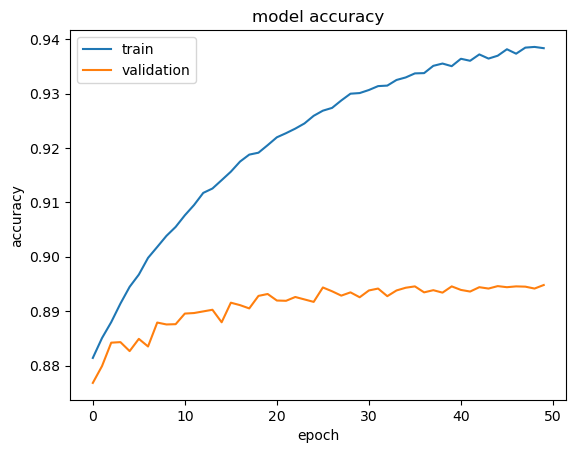

In [57]:
print(history_relu_regul_dynamic.history.keys())
# summarize history for accuracy
plt.plot(history_relu_regul_dynamic.history['accuracy'])
plt.plot(history_relu_regul_dynamic.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

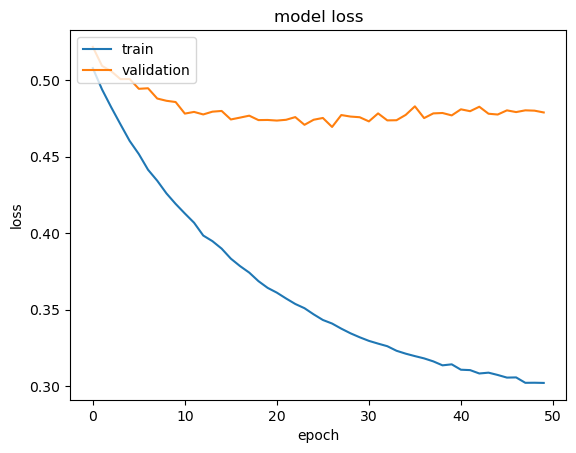

In [58]:
plt.plot(history_relu_regul_dynamic.history['loss'])
plt.plot(history_relu_regul_dynamic.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Можно заметить, что точность улучшилась, но не сильно и с каждой эпохой она увеличивалась постепенно маленькими шажками. При этом, потери на тренировочной выборке и на валидационной стали меньше, чем раньше

## Таким образом, лучшая точность на тренировочной выборке составила: 93,83%
## Лучшая точность на валидационной выборке составила 89,32 %